# Описание проекта

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.



Данные находятся в трёх файлах:
- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.

## План:

1. Подготовьте данные
1.1. Откройте файлы и изучите их.
1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
1.4. Проведите предобработку данных.
2. Проанализируйте данные
2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.
3. Постройте модель
3.1. Напишите функцию для вычисления итоговой sMAPE.
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

# 1. Подготовка данных

In [2]:
#Подгружаю необходимые библиотеки
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
import warnings
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv('gold_recovery_train.csv',parse_dates = ['date']) #обучающая выборка
test=pd.read_csv('gold_recovery_test.csv',parse_dates = ['date']) # тестовая выборка
full=pd.read_csv('gold_recovery_full.csv',parse_dates = ['date']) # исходные данные



In [3]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null datetime64[ns]
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant     

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
ro

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant     

- Датасет full содержит 87 столбцов и 22716 строк. В строках есть пропуски. Скорее всего это из=за того, что они измеряются позже. 
- Датасет train содержит 87 столбцов и 16859 строк. В строках есть пропуски. Скорее всего это из=за того, что они измеряются позже. 
- Датасет test содержит 53 столбцов и 5856 строк. В строках есть пропуски. Скорее всего это из=за того, что они измеряются позже.

### 1.2. Проверька правильности расчета эффективности обогащения

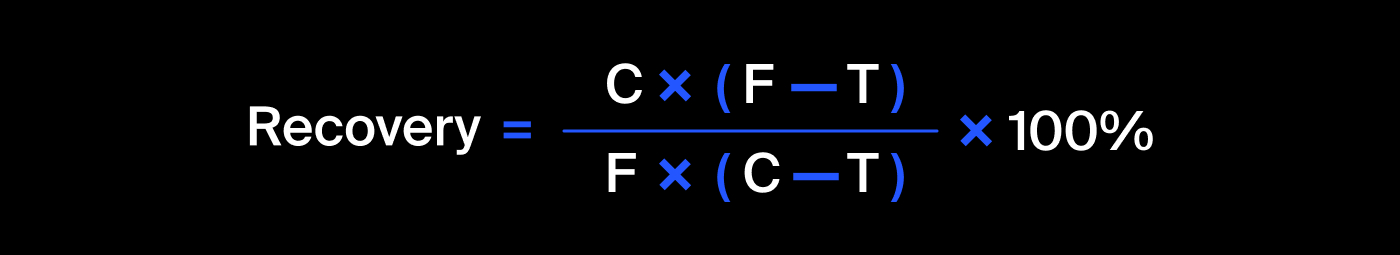

In [6]:
recovery=train

In [7]:
recovery=recovery.dropna().reset_index() 

In [23]:
rougher_output_recovery=recovery['rougher.output.recovery']

In [24]:
rougher_output_tail_au=recovery['rougher.output.tail_au']

In [25]:
rougher_input_feed_au=recovery['rougher.input.feed_au']

In [26]:
rougher_output_concentrate_au=recovery['rougher.output.concentrate_au']

In [12]:
# Заполняю 0 пропуски
#rougher_output_recovery=rougher_output_recovery.fillna(0)
#rougher_output_tail_au=rougher_output_tail_au.fillna(0)
#rougher_input_feed_au=rougher_input_feed_au.fillna(0)
#rougher_output_concentrate_au=rougher_output_concentrate_au.fillna(0)

In [27]:
# Функция Эффективность обогащения
def calc_rougher_output_recovery(rougher_output_concentrate,rougher_input_feed,rougher_output_tail):
    calc_rougher_output_recovery=((rougher_output_concentrate_au*(rougher_input_feed_au-rougher_output_tail_au))/(rougher_input_feed_au*(rougher_output_concentrate_au-rougher_output_tail_au)))*100
    return calc_rougher_output_recovery
    


In [28]:
calc_rougher_output_recovery(rougher_output_concentrate_au,rougher_input_feed_au,rougher_output_tail_au)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
11012    89.574376
11013    87.724007
11014    88.890579
11015    89.858126
11016    89.514960
Length: 11017, dtype: float64

In [14]:
rougher_output_recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
11012    89.574376
11013    87.724007
11014    88.890579
11015    89.858126
11016    89.514960
Name: rougher.output.recovery, Length: 11017, dtype: float64

In [15]:
calc_rougher_output_recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
11012    89.574376
11013    87.724007
11014    88.890579
11015    89.858126
11016    89.514960
Length: 11017, dtype: float64

In [16]:
# Есть ли пропуски
print("The number of nans in calc_rougher_output_recovery: ", calc_rougher_output_recovery.isna().sum())
print("The number of nans in rougher_output_recovery: ", rougher_output_recovery.isna().sum())

The number of nans in calc_rougher_output_recovery:  0
The number of nans in rougher_output_recovery:  0


In [17]:
#calc_rougher_output_recovery=calc_rougher_output_recovery.replace(-np.inf,0)
#calc_rougher_output_recovery=calc_rougher_output_recovery.replace(np.inf,100)

In [18]:
calc_rougher_output_recovery[calc_rougher_output_recovery>0]=100 #Заменяю значения больше 100 на максимально возможное 100
calc_rougher_output_recovery[calc_rougher_output_recovery<0]=0 #Заменяю значения меньше 0 на минимально возможное 100

In [19]:
calc_rougher_output_recovery.min()

-0.0

In [20]:
calc_rougher_output_recovery.max()

100.0

In [21]:
rougher_output_recovery.max()

100.0

### Метрика MAE для проверки расчетного значения rougher_output_recovery и табличного 

In [22]:
mean_absolute_error(calc_rougher_output_recovery,rougher_output_recovery)

15.397350896341308

Абсолютная средняя ошибка получилась 15.4. В целом можно сказать, что значения посчитаны верно. Были значения >100 и <0. Эти значения и сделали ошибку. 

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [23]:
#Признаки в тестовой выборке
test_col=test.columns

In [24]:
#Признаки в полной выборке
full_col=full.columns

In [25]:
#Разница признаков. 
main_list=list(set(full_col)-set(test_col))

In [26]:
# Этих признаков нет в тестовой выборке
main_list=pd.Series(main_list)
main_list.sort_values()

18                          final.output.concentrate_ag
2                           final.output.concentrate_au
13                          final.output.concentrate_pb
9                          final.output.concentrate_sol
12                                final.output.recovery
24                                 final.output.tail_ag
5                                  final.output.tail_au
1                                  final.output.tail_pb
19                                final.output.tail_sol
26                primary_cleaner.output.concentrate_ag
20                primary_cleaner.output.concentrate_au
25                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
27                       primary_cleaner.output.tail_ag
10                       primary_cleaner.output.tail_au
16                       primary_cleaner.output.tail_pb
30                      primary_cleaner.output.tail_sol
3                       rougher.calculation.au_p

 ### Вывод

По сути это выходные признаки после каждого технологического этапа. Каждый из этих признаков можно сделать целевым и предсказывать. Тут присутствуют и наши целевые признаки final.output.recovery и rougher.output.recovery. В дальнейшем они понадобятся на этапе подсчета метрики sMAPE. 

## 1.4. Предобработка

In [27]:
train[train['final.output.concentrate_pb'].isna()].head(5) # Смотрим припуски. Их много.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
746,2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1310,2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311,2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1312,2016-03-09 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930,2016-04-04 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
# Поэтому заполняем последним действительным значением вперед
full=full.fillna(method='ffill')
train=train.fillna(method='ffill') 

In [29]:
full[full['final.output.concentrate_ag'].isna()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


# 2. Анализ данных

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [44]:
# Создаю датасеты с концентрациями металлов на первичной очистке
concetrates_primary=[]
concetrates_primary=pd.DataFrame(concetrates_primary)
concetrates_primary['primary_cleaner.output.concentrate_ag']=full['primary_cleaner.output.concentrate_ag']
concetrates_primary['primary_cleaner.output.concentrate_pb']=full['primary_cleaner.output.concentrate_pb']
concetrates_primary['primary_cleaner.output.concentrate_sol']=full['primary_cleaner.output.concentrate_sol']
concetrates_primary['primary_cleaner.output.concentrate_au']=full['primary_cleaner.output.concentrate_au']

### Boxplot для концентрации металлов

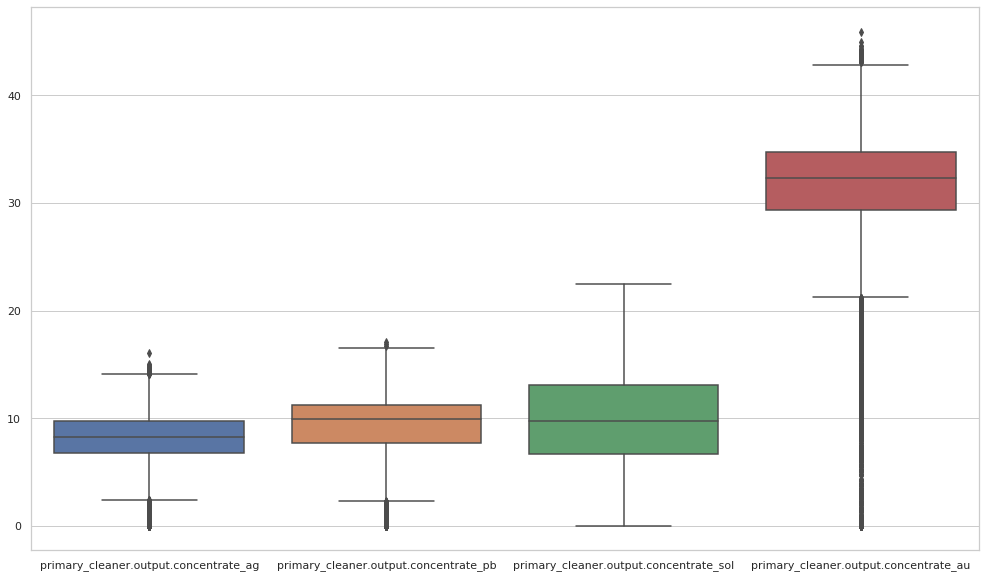

In [45]:
plt.figure(figsize=(17,10))
a=sns.set(style="whitegrid")
a=sns.boxplot(data=concetrates_primary)

In [46]:
# Создаю датасеты с концентрациями металлов на финальной очистке
concetrates_final=[]
concetrates_final=pd.DataFrame(concetrates_final)
concetrates_final['final.output.concentrate_ag']=full['final.output.concentrate_ag']
concetrates_final['final.output.concentrate_pb']=full['final.output.concentrate_pb']
concetrates_final['final.output.concentrate_sol']=full['final.output.concentrate_sol']
concetrates_final['final.output.concentrate_au']=full['final.output.concentrate_au']

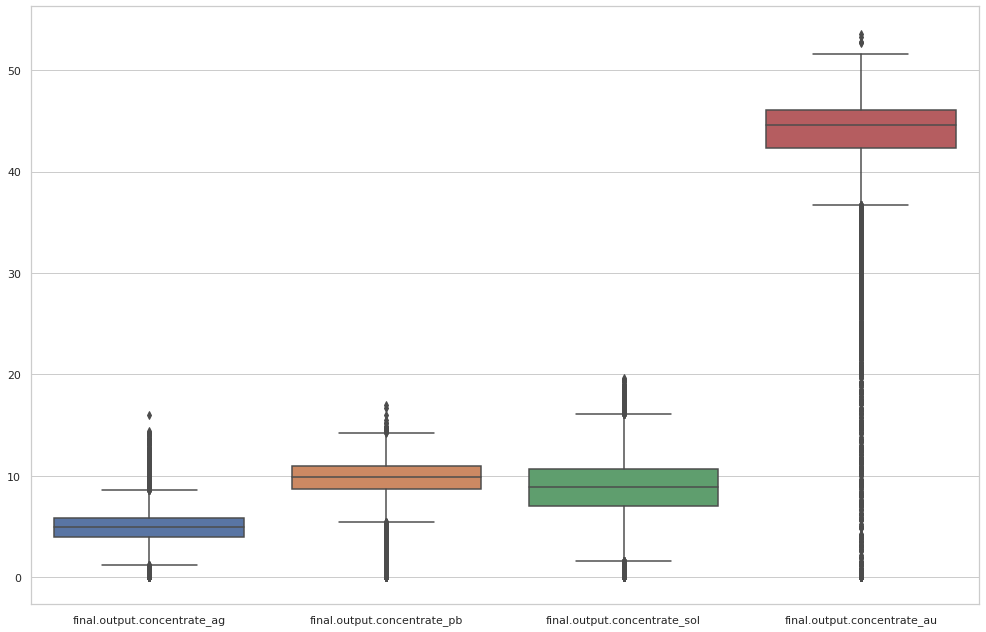

In [47]:
plt.figure(figsize=(17,11))
b=sns.set(style="whitegrid")
b=sns.boxplot(data=concetrates_final)

По "ящику с усами" видно, что имеются выбросы. Особенно их много в концентрации золота (AU) на стадии первичной и финальной очистки. Так же можно наблюдать, что среднее значение концентрации золота на финальной очистке выросло по сравнению с первичной очисткой.

### Распределение на этапе первичной очистки

Text(0, 0.5, 'Friqency')

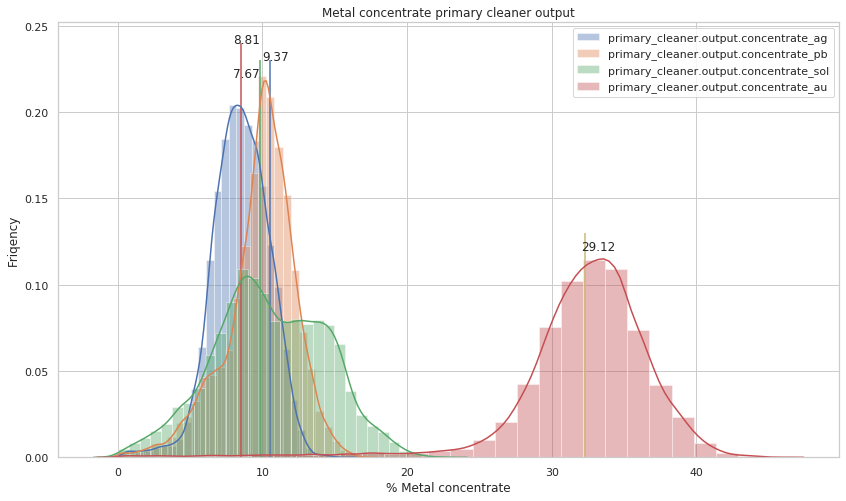

In [48]:
plt.figure(figsize=(14,8))
sns.distplot(full[full['primary_cleaner.output.concentrate_ag']>0.3]['primary_cleaner.output.concentrate_ag'],bins=30,label='primary_cleaner.output.concentrate_ag')
sns.distplot(full[full['primary_cleaner.output.concentrate_pb']>0.01]['primary_cleaner.output.concentrate_pb'],bins=30,label='primary_cleaner.output.concentrate_pb')
sns.distplot(full[full['primary_cleaner.output.concentrate_sol']>0.01]['primary_cleaner.output.concentrate_sol'],bins=30,label='primary_cleaner.output.concentrate_sol')
sns.distplot(full[full['primary_cleaner.output.concentrate_au']>0.01]['primary_cleaner.output.concentrate_au'],bins=30,label='primary_cleaner.output.concentrate_au')
plt.vlines(full[full['primary_cleaner.output.concentrate_ag']>0.3]['primary_cleaner.output.concentrate_ag'].mean(),0,0.24,color = 'r')
plt.vlines(full[full['primary_cleaner.output.concentrate_pb']>0.3]['primary_cleaner.output.concentrate_pb'].mean(),0,0.23,color = 'g')
plt.vlines(full[full['primary_cleaner.output.concentrate_sol']>0.3]['primary_cleaner.output.concentrate_sol'].mean(),0,0.23,color = 'b')
plt.vlines(full[full['primary_cleaner.output.concentrate_au']>0.3]['primary_cleaner.output.concentrate_au'].mean(),0,0.13,color = 'y')

plt.text(8,0.22,round(full['primary_cleaner.output.concentrate_ag'].mean(),2),fontsize=12)
plt.text(8,0.24,round(full['primary_cleaner.output.concentrate_pb'].mean(),2),fontsize=12)
plt.text(10,0.23,round(full['primary_cleaner.output.concentrate_sol'].mean(),2),fontsize=12)
plt.text(32,0.12,round(full['primary_cleaner.output.concentrate_au'].mean(),2),fontsize=12)
plt.legend()
plt.title('Metal concentrate primary cleaner output')
plt.xlabel("% Metal concentrate")
plt.ylabel("Friqency")


### Распределение на этапе финальной очистки

Text(0, 0.5, 'Friqency')

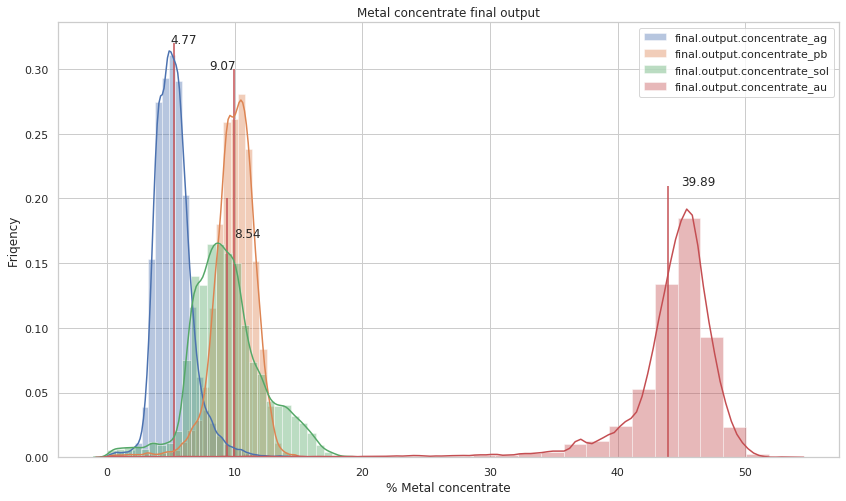

In [49]:
plt.figure(figsize=(14,8))
sns.distplot(full[full['final.output.concentrate_ag']>0.03]['final.output.concentrate_ag'],bins=30,label='final.output.concentrate_ag')
sns.distplot(full[full['final.output.concentrate_pb']>0.03]['final.output.concentrate_pb'],bins=30,label='final.output.concentrate_pb')
sns.distplot(full[full['final.output.concentrate_sol']>0.03]['final.output.concentrate_sol'],bins=30,label='final.output.concentrate_sol')
sns.distplot(full[full['final.output.concentrate_au']>0.03]['final.output.concentrate_au'],bins=30,label='final.output.concentrate_au')
plt.vlines(full[full['final.output.concentrate_ag']>0.3]['final.output.concentrate_ag'].mean(),0,0.32,color = 'r')
plt.vlines(full[full['final.output.concentrate_pb']>0.3]['final.output.concentrate_pb'].mean(),0,0.30,color = 'r')
plt.vlines(full[full['final.output.concentrate_sol']>0.3]['final.output.concentrate_sol'].mean(),0,0.20,color = 'r')
plt.vlines(full[full['final.output.concentrate_au']>0.3]['final.output.concentrate_au'].mean(),0,0.21,color = 'r')

plt.text(5,0.32,round(full['final.output.concentrate_ag'].mean(),2),fontsize=12)
plt.text(8,0.30,round(full['final.output.concentrate_pb'].mean(),2),fontsize=12)
plt.text(10,0.17,round(full['final.output.concentrate_sol'].mean(),2),fontsize=12)
plt.text(45,0.21,round(full['final.output.concentrate_au'].mean(),2),fontsize=12)

plt.legend()
plt.title('Metal concentrate final output')
plt.xlabel("% Metal concentrate")
plt.ylabel("Friqency")


## Выводы

По распределению сонценрации металлов можно увидеть, что распределения поменялись после каждой процедуры обработки. Среднее значение концентрации золота после первичной очистки было 29,2%. После финальной очистки значение средней концентрации золота стало 40%. Расперделение стало более концентрированным вокруг среднего по всем металлам.

### Распределение металла на этапе флотации

Text(0, 0.5, 'Friqency')

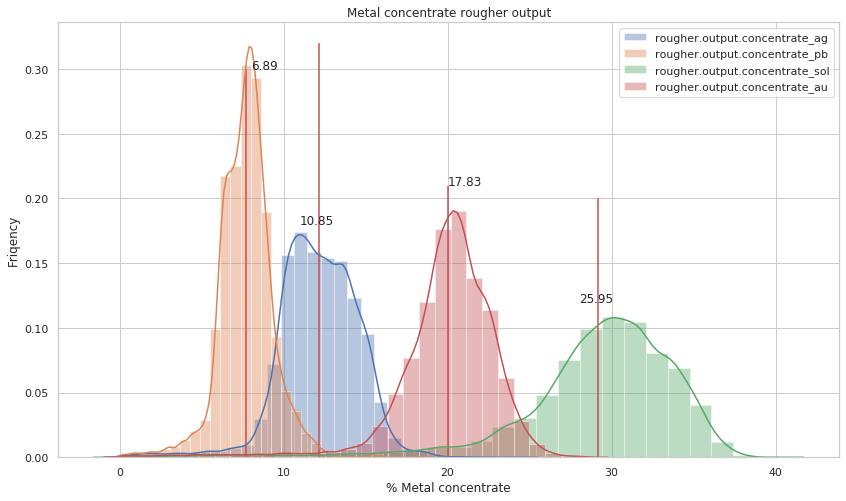

In [50]:
#rougher.output.concentrate_au
plt.figure(figsize=(14,8))
sns.distplot(full[full['rougher.output.concentrate_ag']>0.03]['rougher.output.concentrate_ag'],bins=30,label='rougher.output.concentrate_ag')
sns.distplot(full[full['rougher.output.concentrate_pb']>0.03]['rougher.output.concentrate_pb'],bins=30,label='rougher.output.concentrate_pb')
sns.distplot(full[full['rougher.output.concentrate_sol']>0.03]['rougher.output.concentrate_sol'],bins=30,label='rougher.output.concentrate_sol')
sns.distplot(full[full['rougher.output.concentrate_au']>0.03]['rougher.output.concentrate_au'],bins=30,label='rougher.output.concentrate_au')
plt.vlines(full[full['rougher.output.concentrate_ag']>0.3]['rougher.output.concentrate_ag'].mean(),0,0.32,color = 'r')
plt.vlines(full[full['rougher.output.concentrate_pb']>0.3]['rougher.output.concentrate_pb'].mean(),0,0.30,color = 'r')
plt.vlines(full[full['rougher.output.concentrate_sol']>0.3]['rougher.output.concentrate_sol'].mean(),0,0.20,color = 'r')
plt.vlines(full[full['rougher.output.concentrate_au']>0.3]['rougher.output.concentrate_au'].mean(),0,0.21,color = 'r')

plt.text(11,0.18,round(full['rougher.output.concentrate_ag'].mean(),2),fontsize=12)
plt.text(8,0.30,round(full['rougher.output.concentrate_pb'].mean(),2),fontsize=12)
plt.text(28,0.12,round(full['rougher.output.concentrate_sol'].mean(),2),fontsize=12)
plt.text(20,0.21,round(full['rougher.output.concentrate_au'].mean(),2),fontsize=12)

plt.legend()
plt.title('Metal concentrate rougher output')
plt.xlabel("% Metal concentrate")
plt.ylabel("Friqency")


Видно, что среднее значение золота было 10.87. После флотации оно увеличилось до 29. Почти в 3 раза. Также вместе с золотом увеличилась и концентрация других металлов.

### 2.2  Распределения размеров гранул сырья на обучающей и тестовой выборках

Text(0, 0.5, 'Frequency')

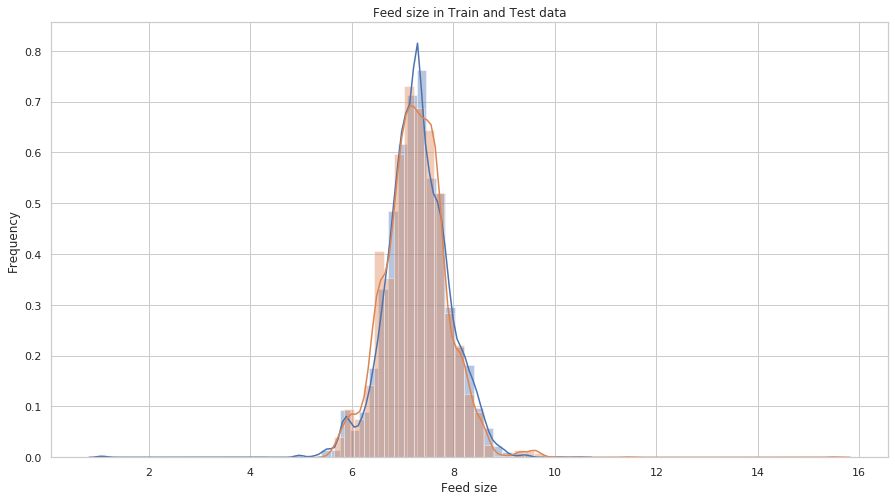

In [51]:
plt.figure(figsize=(15,8))
sns.distplot(train['primary_cleaner.input.feed_size'],label='train primary_cleaner.input.feed_size')
sns.distplot(test['primary_cleaner.input.feed_size'],label='test primary_cleaner.input.feed_size')
plt.title('Feed size in Train and Test data')
plt.legend
plt.xlabel('Feed size')
plt.ylabel('Frequency')

## Выводы

Глядя на распределение обучающей и тестовой выборки можно сказать, что они совпадают, даже без проверки гипотезы t-Стьюдента о равенстве двух генеральных выборок. Можно считать тестовую выборку репрезентативной.

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [52]:
# Считаю сумму концентраций металлов после флотации
full['sum_concentrate_rougher']=full['rougher.output.concentrate_ag']+full['rougher.output.concentrate_pb']+full['rougher.output.concentrate_sol']+full['rougher.output.concentrate_au']


In [53]:
# Считаю сумму концентраций металлов после первичной очистки
full['sum_primary_cleaner_output_concentrate']=full['primary_cleaner.output.concentrate_ag']+full['primary_cleaner.output.concentrate_pb']+full['primary_cleaner.output.concentrate_sol']+full['primary_cleaner.output.concentrate_au']

In [54]:
# Считаю сумму концентраций металлов после финальной очистки
full['sum_final_output_concentrate']=full['final.output.concentrate_ag']+full['final.output.concentrate_pb']+full['final.output.concentrate_sol']+full['final.output.concentrate_au']

In [55]:
sum_concentrate=['sum_concentrate_rougher','sum_primary_cleaner_output_concentrate','sum_final_output_concentrate']

Text(0, 0.5, 'Frequency')

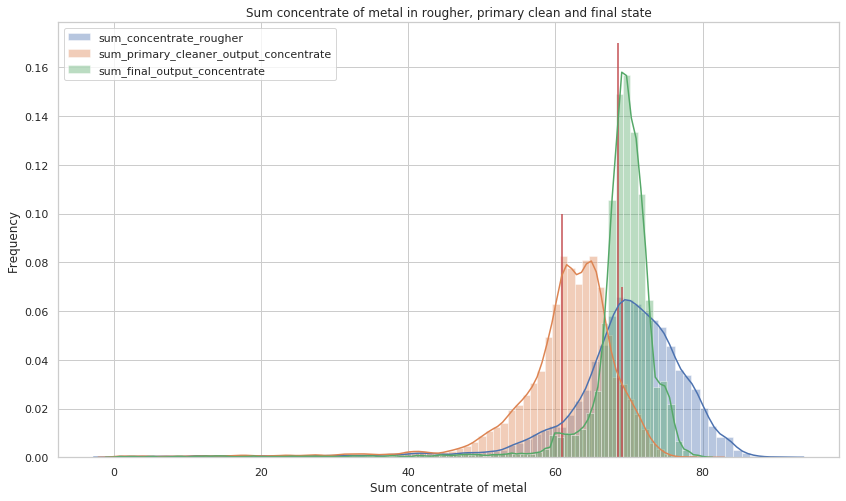

In [56]:
plt.figure(figsize=(14,8))
sns.distplot(full[full['sum_concentrate_rougher']>0.04]['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(full[full['sum_primary_cleaner_output_concentrate']>0.04]['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(full[full['sum_final_output_concentrate']>0.04]['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(full[full['sum_concentrate_rougher']>0.3]['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(full[full['sum_primary_cleaner_output_concentrate']>0.3]['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(full[full['sum_final_output_concentrate']>0.3]['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Sum concentrate of metal in rougher, primary clean and final state')
plt.xlabel("Sum concentrate of metal")
plt.ylabel("Frequency")

По распределению видно, что присутствуют выбросы. Есть много значению от 0 до 40, которые можно удалить. их очень много,а чистота их нулевая. Поэтому, думаю можно их удалить, чтобы не мешали обучению модели.

In [57]:
full=full[full['sum_final_output_concentrate']>40]
full=full[full['sum_primary_cleaner_output_concentrate']>40]
full=full[full['sum_concentrate_rougher']>40]
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,67.012710,72.543485,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,66.103793,72.095042,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,65.752751,59.957723,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,65.908382,71.321010,64.004667


Text(0, 0.5, 'Frequency')

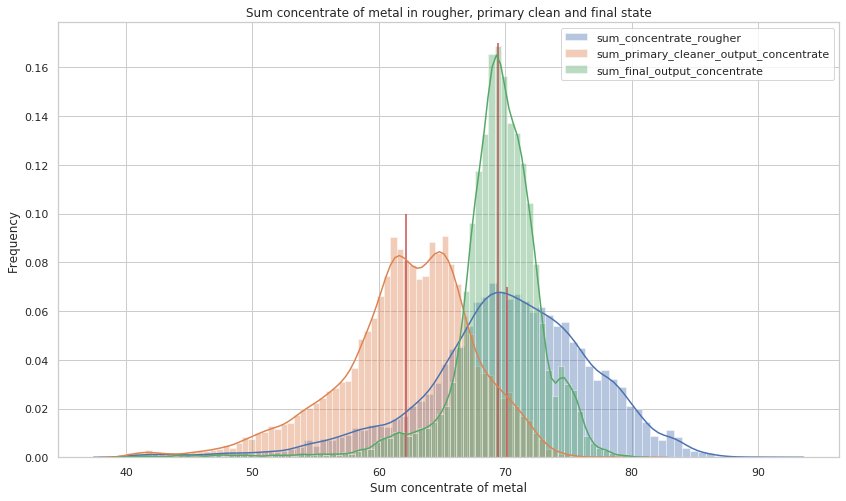

In [58]:
plt.figure(figsize=(14,8))
sns.distplot(full['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(full['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(full['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(full['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(full['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(full['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Sum concentrate of metal in rougher, primary clean and final state')
plt.xlabel("Sum concentrate of metal")
plt.ylabel("Frequency")

Убрали выбросы 40%

In [67]:
# Убираем выбросы из train суммарные концентрации, которых <40
# Считаю сумму концентраций металлов после флотации
train['sum_concentrate_rougher']=train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_pb']+train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au']


In [68]:
# Считаю сумму концентраций металлов после первичной очистки
train['sum_primary_cleaner_output_concentrate']=train['primary_cleaner.output.concentrate_ag']+train['primary_cleaner.output.concentrate_pb']+train['primary_cleaner.output.concentrate_sol']+train['primary_cleaner.output.concentrate_au']


In [69]:
# Считаю сумму концентраций металлов после финальной очистки
train['sum_final_output_concentrate']=train['final.output.concentrate_ag']+train['final.output.concentrate_pb']+train['final.output.concentrate_sol']+train['final.output.concentrate_au']


In [71]:
train=train[train['sum_final_output_concentrate']>40]
train=train[train['sum_primary_cleaner_output_concentrate']>40]
train=train[train['sum_concentrate_rougher']>40]
train=train.reset_index()
train.head()

,level_0,index,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate
0,0,0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,1,1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,67.012710,72.543485,63.957723
2,2,2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,66.103793,72.095042,64.311180
3,3,3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,65.752751,59.957723,63.573449
4,4,4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,65.908382,71.321010,64.004667


Text(0, 0.5, 'Frequency')

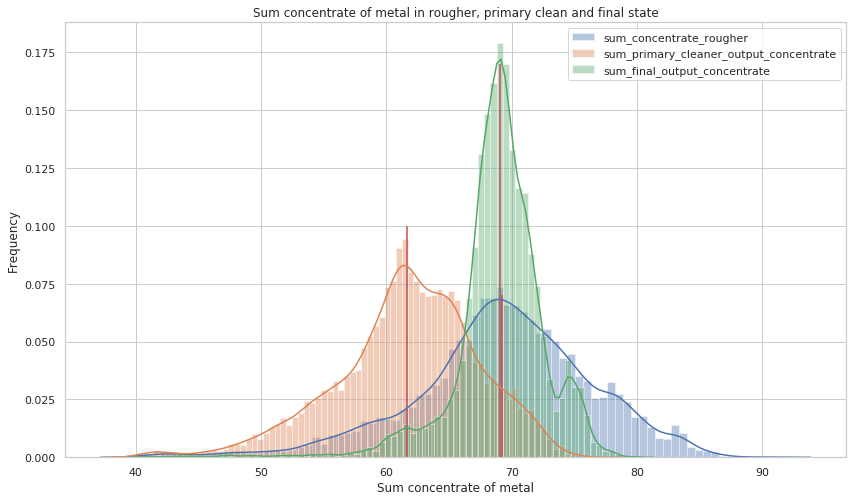

In [63]:
plt.figure(figsize=(14,8))
sns.distplot(train['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(train['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(train['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(train['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(train['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(train['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Sum concentrate of metal in rougher, primary clean and final state')
plt.xlabel("Sum concentrate of metal")
plt.ylabel("Frequency")

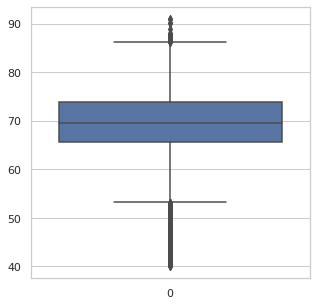

In [72]:
plt.figure(figsize=(5,5))
b=sns.set(style="whitegrid")
b=sns.boxplot(data=train['sum_concentrate_rougher'])


# 3. Модель

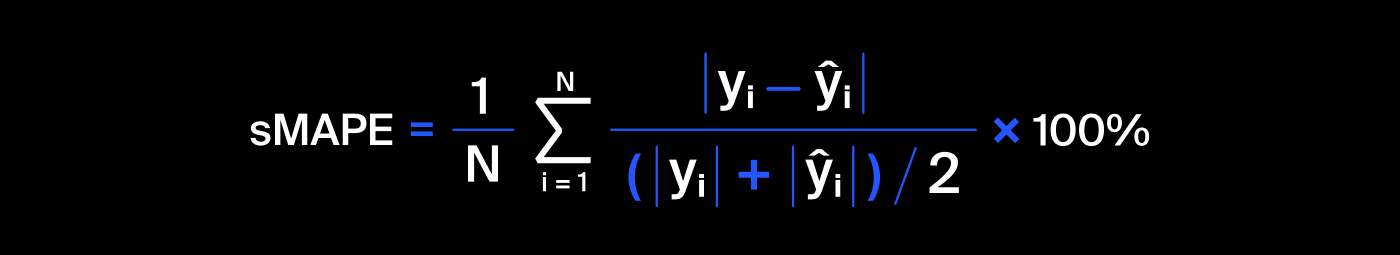

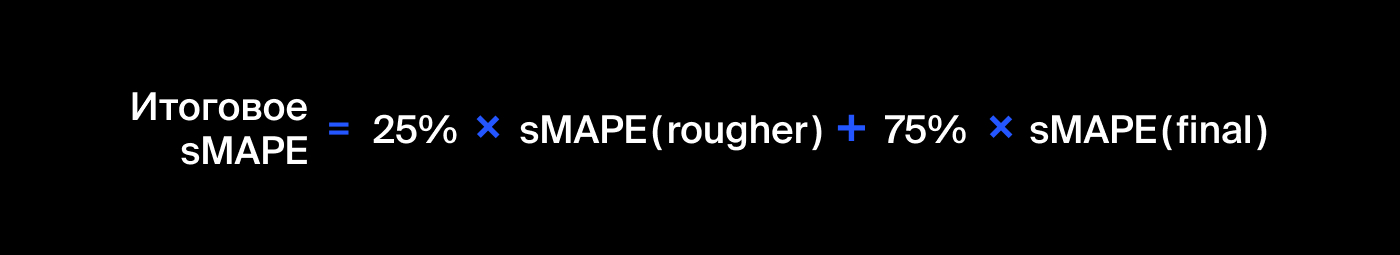

In [73]:
# Функция метрики качества
def sMAPE(predict,target):
    predict_rougher=predict[:,0]
    target__rougher=target[:,0]
    predict_final=predict[:,1]
    target__final=target[:,1]
    
    sMAPE_rougher=np.sum(abs(target__rougher-predict_rougher)/((abs(target__rougher)+abs(predict_rougher))/2))
    

    sMAPE_rougher=sMAPE_rougher/len(target__rougher)*100
    
   
    sMAPE_final=np.sum(abs(target__final-predict_final)/((abs(target__final)+abs(predict_final))/2))
    sMAPE_final=sMAPE_final/len(target__final)*100
    
    sMAP=0.25*sMAPE_rougher+0.75*sMAPE_final
    return sMAP

In [74]:
columns=test.columns # Колонки которые в тестовой выборке

In [75]:
feature=train[columns] # Формируем признаки Выбираем из trian только те колонки, которые есть в test
feature=feature.drop(['date'],axis=1)
target=train[['rougher.output.recovery','final.output.recovery']] # Формируем вектор целевых признаков


In [76]:
target_array=np.array(target) # конвертирую в array

In [77]:
sample_size=int(len(target)/6)#Формирую длину датасета для кровв-валидации. Их будет 4

In [80]:
# Кросс-валидация Линейная регрессия
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
   
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
    model_regression=LinearRegression().fit(feature_train,target_train)
    prediction_regress=model_regression.predict(feature_valid)   
    
    mae=mean_absolute_error(prediction_regress,target_valid)
    mae_score.append(mae)
    smape=sMAPE(prediction_regress,target_valid_arr)
    smape_score.append(smape)
    
    #print(mae_score)

print(np.mean(mae_score))
print(np.mean(smape_score))


5.58188903572917
8.77465128364495


In [55]:
# Кросс-валидация Случайный лес
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    for i in range(1,5,1):
        
        model_forest=RandomForestRegressor(random_state=1234,max_depth=i,n_estimators=10).fit(feature_train,target_train)
        prediction_forest=model_forest.predict(feature_valid)
        mae=mean_absolute_error(prediction_forest,target_valid)
        mae_score.append(mae)
        smape=sMAPE(prediction_forest,target_valid_arr)
        smape_score.append(smape)
        
        print('max_depth:',i,'MAE:',np.mean(mae_score))
        print('max_depth:',i,'sMAPE:',np.mean(smape_score))

max_depth: 1 MAE: 5.871229854857809
max_depth: 1 sMAPE: 9.575119425416645
max_depth: 2 MAE: 5.7968541990577105
max_depth: 2 sMAPE: 9.463395750464136
max_depth: 3 MAE: 5.743253293526247
max_depth: 3 sMAPE: 9.36934539203887
max_depth: 4 MAE: 5.765209169918857
max_depth: 4 sMAPE: 9.375247494053013
max_depth: 1 MAE: 5.920371878771364
max_depth: 1 sMAPE: 9.251927236026726
max_depth: 2 MAE: 5.9462653796603115
max_depth: 2 sMAPE: 9.073613272618418
max_depth: 3 MAE: 5.928221280868631
max_depth: 3 sMAPE: 8.918702995711007
max_depth: 4 MAE: 5.904539443753714
max_depth: 4 sMAPE: 8.819628658561108
max_depth: 1 MAE: 5.873948816317043
max_depth: 1 sMAPE: 8.726641283030954
max_depth: 2 MAE: 5.840353214930718
max_depth: 2 sMAPE: 8.643439046139996
max_depth: 3 MAE: 5.84976020231868
max_depth: 3 sMAPE: 8.608523227480706
max_depth: 4 MAE: 5.836080257092282
max_depth: 4 sMAPE: 8.560473784022438
max_depth: 1 MAE: 5.90876108580015
max_depth: 1 sMAPE: 8.780426099947622
max_depth: 2 MAE: 5.9166488326164215
ma

In [81]:
 # берем значение max_depth=3 и n_estimators=5
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
        
    model_forest=RandomForestRegressor(random_state=1234,max_depth=3,n_estimators=5).fit(feature_train,target_train)
    prediction_forest=model_forest.predict(feature_valid)
    mae=mean_absolute_error(prediction_forest,target_valid)
    mae_score.append(mae)
    smape=sMAPE(prediction_forest,target_valid_arr)
    smape_score.append(smape)
        
print('MAE:',np.mean(mae_score))
print('sMAPE:',np.mean(smape_score))
        
        

MAE: 5.57417936845608
sMAPE: 8.242719280254388


In [79]:
# Кросс-валидация для LinearSVR
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
    target_train_1=target_train.iloc[:,0]
    target_train_2=target_train.iloc[:,1]
    
    #target_valid_1['rougher.output.recovery']=target_valid['rougher.output.recovery']
    #target_valid_2['final.output.recovery']=target_valid['final.output.recovery']
    
    
    model_regressionSVR_1=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
    intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
    random_state=0, tol=1e-05, verbose=0).fit(feature_train,target_train_1)
    prediction_regressSVR_rouger=model_regressionSVR_1.predict(feature_valid)   
    
    model_regressionSVR_2=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
    intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
    random_state=0, tol=1e-05, verbose=0).fit(feature_train,target_train_2)
    prediction_regressSVR_final=model_regressionSVR_2.predict(feature_valid)   
    
    #mae=mean_absolute_error(prediction_regressSVR_2,target_valid['rougher.output.recovery'])
    #mae_score.append(mae)
    
    prediction_regressSVR=pd.DataFrame(prediction_regressSVR_rouger)
    prediction_regressSVR['final.output.recovery']=pd.DataFrame(prediction_regressSVR_final)
    prediction_regressSVR.set_axis(['rougher.output.recovery','final.output.recovery'],axis='columns',inplace=True)
    prediction_regressSVR=np.array(prediction_regressSVR)
    smape=sMAPE(prediction_regressSVR,target_valid_arr)
    smape_score.append(smape)
    
    #print(mae_score)

#print(np.mean(mae_score))
print(np.mean(smape_score))


22.77285819229314


### Предсказания на тестовом наборе данных

In [82]:
target=full[['date','rougher.output.recovery','final.output.recovery']]

In [83]:
test=test.merge(target,on=['date'],how='left')

In [84]:
test=test.dropna()


In [85]:
target=test[['rougher.output.recovery','final.output.recovery']]


In [86]:
feature=test.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)


In [87]:
prediction_reg=model_regression.predict(feature)


In [88]:
smape_line=sMAPE(prediction_reg,np.array(target))
smape_line

7.093395134845503

In [89]:
prediction_forest=model_forest.predict(feature)

In [90]:
smape_forest=sMAPE(prediction_forest,np.array(target))
smape_forest

7.445634095874103

In [91]:
prediction_regressSVR_rouger=model_regressionSVR_1.predict(feature) 
prediction_regressSVR_final=model_regressionSVR_2.predict(feature) 

In [92]:
prediction_regressSVR=pd.DataFrame(prediction_regressSVR_rouger)
prediction_regressSVR['final.output.recovery']=pd.DataFrame(prediction_regressSVR_final)
prediction_regressSVR.set_axis(['rougher.output.recovery','final.output.recovery'],axis='columns',inplace=True)
prediction_regressSVR=np.array(prediction_regressSVR)

In [93]:
smape_line_svr=sMAPE(prediction_regressSVR,np.array(target))
smape_line_svr

7.0384879408686345

### Вывод

In [94]:
models=['LinearRegression','RandomForestRegressor','LinearSVR']

In [95]:
sMAPE_rezult=pd.DataFrame(np.array([smape_line,smape_forest,smape_line_svr]),index=models)
sMAPE_rezult.set_axis(['sMAPE'],axis='columns',inplace=True)
sMAPE_rezult

,sMAPE
LinearRegression,7.093395
RandomForestRegressor,7.445634
LinearSVR,7.038488


По сводной таблице видно, что лучше всего себя показала модель LinearSVR=7.038488. Возможно если удалить аномалии из test то sMAPE будут лучше, но я не согласен, что их надо удалять, т.к получается, что мы специально подгоняем тестовую выборку для хорошего результата.